# Football xG Modelling 

In [1]:
!pip install mplsoccer
!pip install xgboost
!pip install lightgbm
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 21.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.3 MB/s eta 0:00:00


### Importing Datasets

In [2]:
df= pd.read_csv('xg_model.csv')
df.shape #Contains 24 features and 1 target variable which is if it is a goal

(8118, 25)

In [3]:
df.head()

,x,y,is_goal,period,Assisted,Zone,IndividualPlay,RegularPlay,LeftFoot,RightFoot,...,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OwnGoal,OtherBodyPart,DirectCorner
0,80.8,51.6,False,SecondHalf,True,Center,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79.3,24.2,False,SecondHalf,True,Center,True,True,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,80.0,59.5,False,SecondHalf,True,Center,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89.8,55.6,False,SecondHalf,True,Center,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84.9,56.2,False,SecondHalf,True,Center,NaN,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['OwnGoal'].value_counts() # 0 is no goal, 1 is goal

OwnGoal
True    27
Name: count, dtype: int64

In [5]:
df=df.drop(df[df['OwnGoal'] == 1].index) # Drop the rows with a goal


In [6]:
df.drop(['OwnGoal'], axis=1, inplace=True) # Drop own goal column

In [7]:
df.shape

(8091, 24)

In [8]:
print(df.isna().sum()) # Check for missing values

x                     0
y                     0
is_goal               0
period                0
Assisted           2053
Zone                  0
IndividualPlay     5289
RegularPlay        2714
LeftFoot           5307
RightFoot          4106
FromCorner         6903
FirstTouch         4166
Head               6793
BigChance          6484
SetPiece           7704
Volley             7281
FastBreak          7476
ThrowinSetPiece    7904
Penalty            7985
OneOnOne           7890
KeyPass            8033
DirectFreekick     7860
OtherBodyPart      8067
DirectCorner       8089
dtype: int64


In [9]:
df.fillna(0, inplace=True) # Fill missing values with 0

In [10]:
df.head()

,x,y,is_goal,period,Assisted,Zone,IndividualPlay,RegularPlay,LeftFoot,RightFoot,...,SetPiece,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner
0,80.8,51.6,False,SecondHalf,True,Center,True,True,True,0,...,0,0,0,0,0,0,0,0,0,0
1,79.3,24.2,False,SecondHalf,True,Center,True,True,0,True,...,0,0,0,0,0,0,0,0,0,0
2,80.0,59.5,False,SecondHalf,True,Center,0,0,0,True,...,0,0,0,0,0,0,0,0,0,0
3,89.8,55.6,False,SecondHalf,True,Center,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,84.9,56.2,False,SecondHalf,True,Center,0,True,True,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
goal_x, goal_y = 100, 50

df["shot_distance (m)"] = np.sqrt((df['x'] - goal_x)**2 + (df['y'] - goal_y)**2)

In [12]:
df.head()

,x,y,is_goal,period,Assisted,Zone,IndividualPlay,RegularPlay,LeftFoot,RightFoot,...,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner,shot_distance (m)
0,80.8,51.6,False,SecondHalf,True,Center,True,True,True,0,...,0,0,0,0,0,0,0,0,0,19.266551
1,79.3,24.2,False,SecondHalf,True,Center,True,True,0,True,...,0,0,0,0,0,0,0,0,0,33.077636
2,80.0,59.5,False,SecondHalf,True,Center,0,0,0,True,...,0,0,0,0,0,0,0,0,0,22.141590
3,89.8,55.6,False,SecondHalf,True,Center,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.636151
4,84.9,56.2,False,SecondHalf,True,Center,0,True,True,0,...,0,0,0,0,0,0,0,0,0,16.323296


In [13]:
df.columns

Index(['x', 'y', 'is_goal', 'period', 'Assisted', 'Zone', 'IndividualPlay',
       'RegularPlay', 'LeftFoot', 'RightFoot', 'FromCorner', 'FirstTouch',
       'Head', 'BigChance', 'SetPiece', 'Volley', 'FastBreak',
       'ThrowinSetPiece', 'Penalty', 'OneOnOne', 'KeyPass', 'DirectFreekick',
       'OtherBodyPart', 'DirectCorner', 'shot_distance (m)'],
      dtype='object')

In [14]:
df.head()

,x,y,is_goal,period,Assisted,Zone,IndividualPlay,RegularPlay,LeftFoot,RightFoot,...,Volley,FastBreak,ThrowinSetPiece,Penalty,OneOnOne,KeyPass,DirectFreekick,OtherBodyPart,DirectCorner,shot_distance (m)
0,80.8,51.6,False,SecondHalf,True,Center,True,True,True,0,...,0,0,0,0,0,0,0,0,0,19.266551
1,79.3,24.2,False,SecondHalf,True,Center,True,True,0,True,...,0,0,0,0,0,0,0,0,0,33.077636
2,80.0,59.5,False,SecondHalf,True,Center,0,0,0,True,...,0,0,0,0,0,0,0,0,0,22.141590
3,89.8,55.6,False,SecondHalf,True,Center,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11.636151
4,84.9,56.2,False,SecondHalf,True,Center,0,True,True,0,...,0,0,0,0,0,0,0,0,0,16.323296


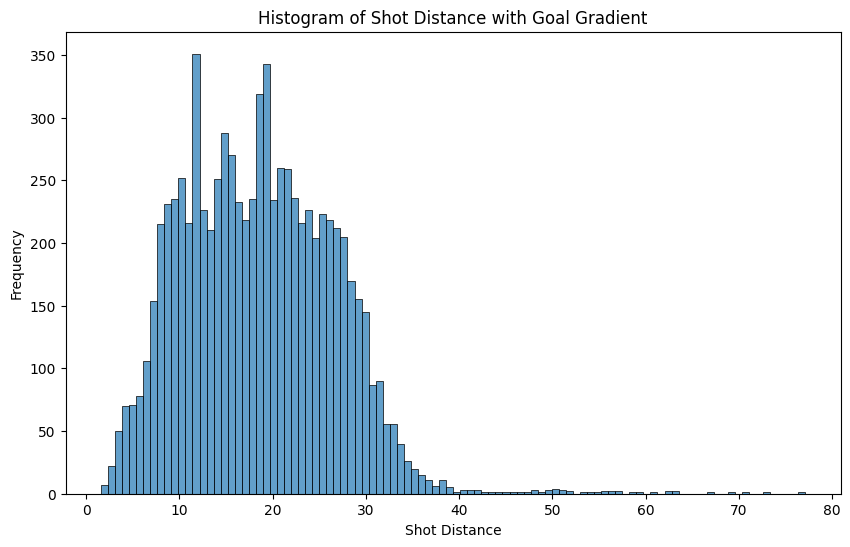

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='shot_distance (m)', kde=False, palette='coolwarm', bins=100, alpha=0.7)
plt.title("Histogram of Shot Distance with Goal Gradient")
plt.xlabel("Shot Distance")
plt.ylabel("Frequency")
plt.show()

<Axes: xlabel='x', ylabel='y'>

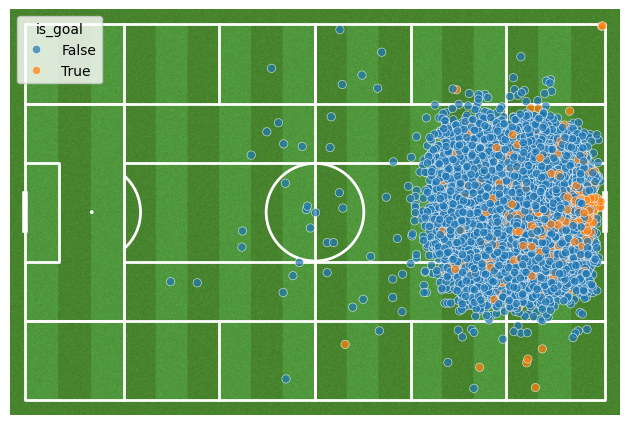

In [16]:
from mplsoccer import Pitch
pitch = Pitch(pitch_type='opta', pitch_color='grass', line_color='white',
              stripe_color='#c2d59d', stripe=True, positional=True, positional_color='white')

fig, ax = pitch.draw()

# Scatter plot
sns.scatterplot(x='x', y='y', data=df, hue='is_goal', alpha=0.7, ax=ax)

In [17]:
df.dtypes

x                    float64
y                    float64
is_goal                 bool
period                object
Assisted              object
Zone                  object
IndividualPlay        object
RegularPlay           object
LeftFoot              object
RightFoot             object
FromCorner            object
FirstTouch            object
Head                  object
BigChance             object
SetPiece              object
Volley                object
FastBreak             object
ThrowinSetPiece       object
Penalty               object
OneOnOne              object
KeyPass               object
DirectFreekick        object
OtherBodyPart         object
DirectCorner          object
shot_distance (m)    float64
dtype: object

In [18]:
df = df.astype({
    'x': float,
    'y': float,
    'is_goal': bool,
    'period': str,
    'Assisted': bool,
    'Zone': str,
    'IndividualPlay':bool,
    'RegularPlay':bool,
    'LeftFoot':bool,
    'RightFoot':bool,
    'FromCorner':bool,
    'FirstTouch':bool, 
    'Head':bool,
    'BigChance': bool, 
    'SetPiece': bool,
    'Volley': bool,
    'FastBreak':bool,
    'ThrowinSetPiece':bool,
    'Penalty':bool, 
    'OneOnOne':bool,
    'KeyPass': bool,
    'OtherBodyPart': bool,
    'shot_distance (m)': float
})

In [19]:
df.dtypes

x                    float64
y                    float64
is_goal                 bool
period                object
Assisted                bool
Zone                  object
IndividualPlay          bool
RegularPlay             bool
LeftFoot                bool
RightFoot               bool
FromCorner              bool
FirstTouch              bool
Head                    bool
BigChance               bool
SetPiece                bool
Volley                  bool
FastBreak               bool
ThrowinSetPiece         bool
Penalty                 bool
OneOnOne                bool
KeyPass                 bool
DirectFreekick        object
OtherBodyPart           bool
DirectCorner          object
shot_distance (m)    float64
dtype: object

In [20]:
df = pd.get_dummies(df, columns=['period', 'Zone'])

In [21]:
df.dtypes

x                    float64
y                    float64
is_goal                 bool
Assisted                bool
IndividualPlay          bool
RegularPlay             bool
LeftFoot                bool
RightFoot               bool
FromCorner              bool
FirstTouch              bool
Head                    bool
BigChance               bool
SetPiece                bool
Volley                  bool
FastBreak               bool
ThrowinSetPiece         bool
Penalty                 bool
OneOnOne                bool
KeyPass                 bool
DirectFreekick        object
OtherBodyPart           bool
DirectCorner          object
shot_distance (m)    float64
period_FirstHalf        bool
period_SecondHalf       bool
Zone_Back               bool
Zone_Center             bool
Zone_Left               bool
Zone_Right              bool
dtype: object

In [22]:
df.head()

,x,y,is_goal,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,...,DirectFreekick,OtherBodyPart,DirectCorner,shot_distance (m),period_FirstHalf,period_SecondHalf,Zone_Back,Zone_Center,Zone_Left,Zone_Right
0,80.8,51.6,False,True,True,True,True,False,False,False,...,0,False,0,19.266551,False,True,False,True,False,False
1,79.3,24.2,False,True,True,True,False,True,False,False,...,0,False,0,33.077636,False,True,False,True,False,False
2,80.0,59.5,False,True,False,False,False,True,True,False,...,0,False,0,22.141590,False,True,False,True,False,False
3,89.8,55.6,False,True,False,False,False,False,True,True,...,0,False,0,11.636151,False,True,False,True,False,False
4,84.9,56.2,False,True,False,True,True,False,False,False,...,0,False,0,16.323296,False,True,False,True,False,False


In [23]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [24]:
label_enc = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_enc.fit_transform(df[col])


In [25]:
X= df.drop(['is_goal'], axis=1)
y= df['is_goal']
X.shape, y.shape

((8091, 28), (8091,))

In [26]:
X_train, y_train=X, y

In [27]:
df2=pd.read_csv('Test/All_shots_realistic.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Test/All_shots_realistic.csv'

In [ ]:
df2.shape

(400, 30)

In [ ]:
df2.head()

,player_name,x,y,is_goal,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,...,DirectFreekick,OtherBodyPart,DirectCorner,shot_distance (m),period_FirstHalf,period_SecondHalf,Zone_Back,Zone_Center,Zone_Left,Zone_Right
0,Akash,60.913824,48.245528,False,False,True,True,True,False,False,...,0,False,0,39.125533,False,True,True,False,False,False
1,Akash,63.979926,50.003274,True,False,True,True,True,False,False,...,1,False,1,36.020074,True,False,True,False,False,False
2,Akash,75.964828,59.448978,False,False,True,True,True,False,False,...,0,False,0,25.825815,False,True,False,False,True,False
3,Akash,64.831862,41.618975,False,False,True,True,True,False,False,...,0,False,1,36.153002,True,False,False,True,False,False
4,Akash,95.794896,42.907939,False,True,False,True,False,True,False,...,0,False,1,8.245013,True,False,False,False,False,True


In [ ]:
# count the number of is_goal=True and save it in a variable
num_goals = df2['is_goal'].value_counts()[1]    
print(f"Number of goals: {num_goals}")

Number of goals: 184


C:\Users\akash\AppData\Local\Temp\ipykernel_38320\2475363094.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_goals = df2['is_goal'].value_counts()[1]


In [ ]:
X_test = df2.drop(['player_name','is_goal'], axis=1)
y_test = df2['is_goal']     
X_test.shape, y_test.shape


((400, 28), (400,))

In [ ]:
df.columns

Index(['x', 'y', 'is_goal', 'Assisted', 'IndividualPlay', 'RegularPlay',
       'LeftFoot', 'RightFoot', 'FromCorner', 'FirstTouch', 'Head',
       'BigChance', 'SetPiece', 'Volley', 'FastBreak', 'ThrowinSetPiece',
       'Penalty', 'OneOnOne', 'KeyPass', 'DirectFreekick', 'OtherBodyPart',
       'DirectCorner', 'shot_distance (m)', 'period_FirstHalf',
       'period_SecondHalf', 'Zone_Back', 'Zone_Center', 'Zone_Left',
       'Zone_Right'],
      dtype='object')

In [ ]:
df.head()

,x,y,is_goal,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,...,DirectFreekick,OtherBodyPart,DirectCorner,shot_distance (m),period_FirstHalf,period_SecondHalf,Zone_Back,Zone_Center,Zone_Left,Zone_Right
0,80.8,51.6,False,True,True,True,True,False,False,False,...,0,False,0,19.266551,False,True,False,True,False,False
1,79.3,24.2,False,True,True,True,False,True,False,False,...,0,False,0,33.077636,False,True,False,True,False,False
2,80.0,59.5,False,True,False,False,False,True,True,False,...,0,False,0,22.141590,False,True,False,True,False,False
3,89.8,55.6,False,True,False,False,False,False,True,True,...,0,False,0,11.636151,False,True,False,True,False,False
4,84.9,56.2,False,True,False,True,True,False,False,False,...,0,False,0,16.323296,False,True,False,True,False,False


In [ ]:
# Sklearn Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

#### Function for hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
def hyperparameter_tuning(X_train, y_train):
    # Define models and their hyperparameter grids
    models_and_params = {
        "Logistic Regression": {
            "model": LogisticRegression(max_iter=1000),
            "params": {
                "C": [0.01, 0.1, 1, 10],
                "penalty": ["l2"],
                "solver": ["lbfgs", "liblinear"]
            }
        },
        "Decision Tree": {
            "model": DecisionTreeClassifier(),
            "params": {
                "max_depth": [3, 5, 10, None],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            }
        },
        "Random Forest": {
            "model": RandomForestClassifier(),
            "params": {
                "n_estimators": [50, 100, 200],
                "max_depth": [3, 5, 10, None],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4]
            }
        },
        "Gradient Boosting": {
            "model": GradientBoostingClassifier(),
            "params": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 0.2],
                "max_depth": [3, 5, 10]
            }
        },
        "AdaBoost": {
            "model": AdaBoostClassifier(),
            "params": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 0.5, 1.0]
            }
        },
        "K-Nearest Neighbors": {
            "model": KNeighborsClassifier(),
            "params": {
                "n_neighbors": [3, 5, 10],
                "weights": ["uniform", "distance"],
                "metric": ["euclidean", "manhattan"]
            }
        },
        "Naive Bayes": {
            "model": GaussianNB(),
            "params": {
                "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
            }
        },
        "XGBoost": {
            "model": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
            "params": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.01, 0.1, 0.2],
                "max_depth": [3, 5, 7],
                "subsample": [0.6, 0.8, 1.0]
            }
        }
    }

    # Dictionary to store the best models and their parameters
    best_models = {}

    # Perform GridSearchCV for each model
    for model_name, model_info in models_and_params.items():
        print(f"Tuning hyperparameters for {model_name}...")
        grid_search = GridSearchCV(
            estimator=model_info["model"],
            param_grid=model_info["params"],
            cv=5,
            scoring="accuracy",
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_models[model_name] = {
            "best_estimator": grid_search.best_estimator_,
            "best_params": grid_search.best_params_,
            "best_score": grid_search.best_score_
        }
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best accuracy for {model_name}: {grid_search.best_score_}\n")

    return best_models

Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy for Logistic Regression: 0.8911127212314213

Tuning hyperparameters for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best accuracy for Decision Tree: 0.8908655787920179

Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best accuracy for Random Forest: 0.8928432527518169

Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best accuracy for Gradient Boosting: 0.8914840075097097

Tuning hyperparameters for AdaBoost...
Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 100}
Best accuracy for AdaBoost: 0.8917306155045424

Tuning hyperparameter

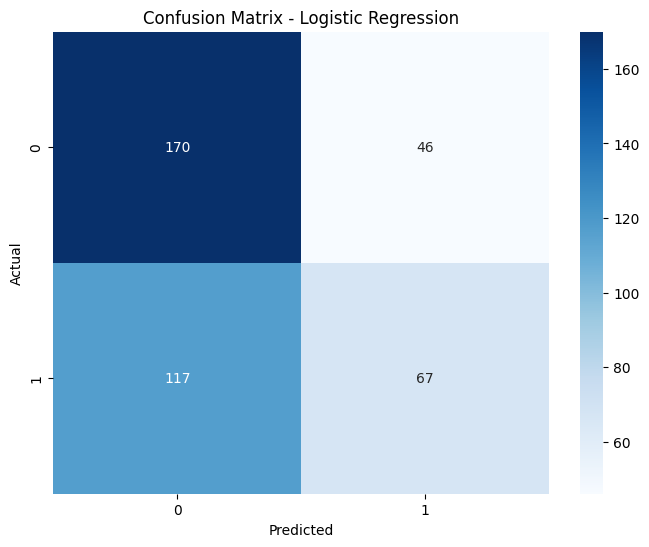

Accuracy of Decision Tree on test set: 0.5500
Classification Report for Decision Tree:
               precision    recall  f1-score   support

       False       0.55      0.99      0.70       216
        True       0.75      0.03      0.06       184

    accuracy                           0.55       400
   macro avg       0.65      0.51      0.38       400
weighted avg       0.64      0.55      0.41       400



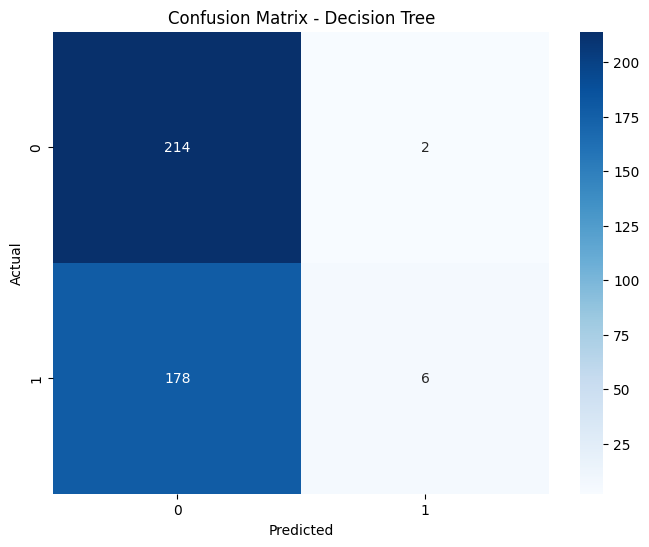

Accuracy of Random Forest on test set: 0.5500
Classification Report for Random Forest:
               precision    recall  f1-score   support

       False       0.55      0.99      0.70       216
        True       0.75      0.03      0.06       184

    accuracy                           0.55       400
   macro avg       0.65      0.51      0.38       400
weighted avg       0.64      0.55      0.41       400



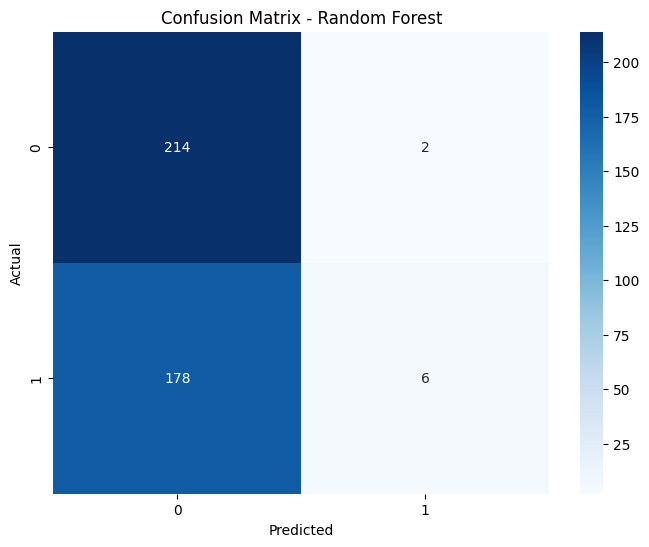

Accuracy of Gradient Boosting on test set: 0.5300
Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

       False       0.54      0.95      0.69       216
        True       0.38      0.03      0.06       184

    accuracy                           0.53       400
   macro avg       0.46      0.49      0.37       400
weighted avg       0.46      0.53      0.40       400



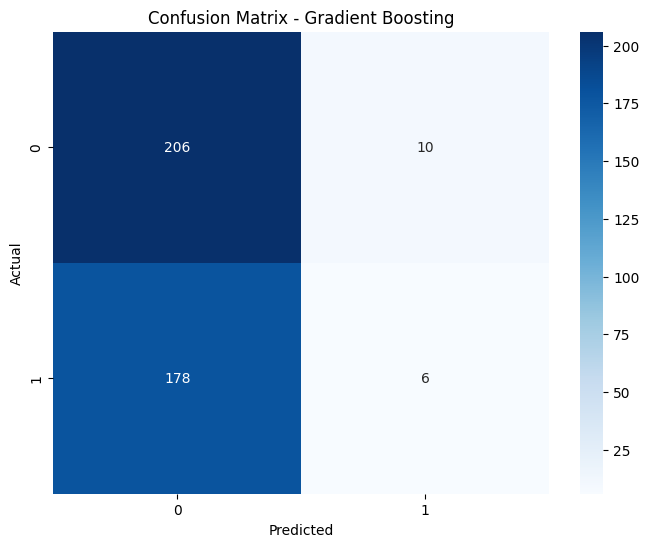

Accuracy of AdaBoost on test set: 0.5475
Classification Report for AdaBoost:
               precision    recall  f1-score   support

       False       0.54      0.99      0.70       216
        True       0.71      0.03      0.05       184

    accuracy                           0.55       400
   macro avg       0.63      0.51      0.38       400
weighted avg       0.62      0.55      0.40       400



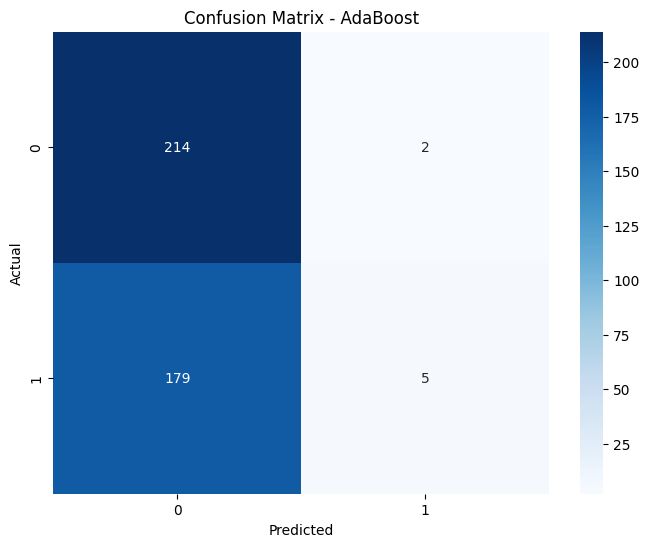

Accuracy of K-Nearest Neighbors on test set: 0.5550
Classification Report for K-Nearest Neighbors:
               precision    recall  f1-score   support

       False       0.55      0.98      0.70       216
        True       0.71      0.05      0.10       184

    accuracy                           0.56       400
   macro avg       0.63      0.52      0.40       400
weighted avg       0.63      0.56      0.43       400



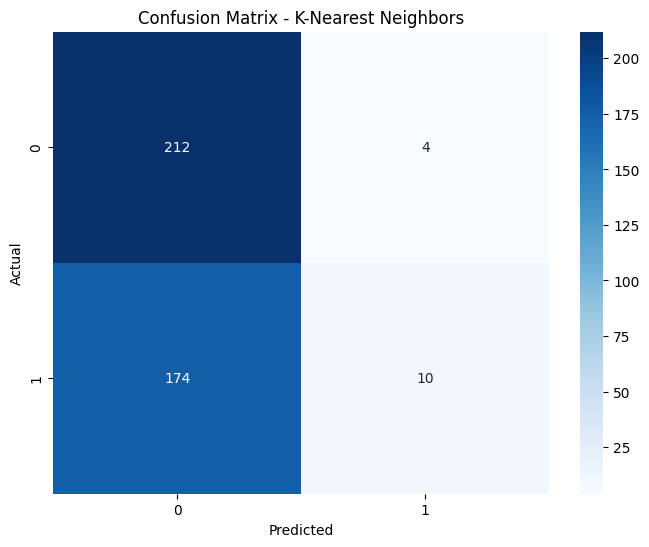

Accuracy of Naive Bayes on test set: 0.5375
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

       False       0.55      0.81      0.65       216
        True       0.49      0.22      0.31       184

    accuracy                           0.54       400
   macro avg       0.52      0.51      0.48       400
weighted avg       0.52      0.54      0.49       400



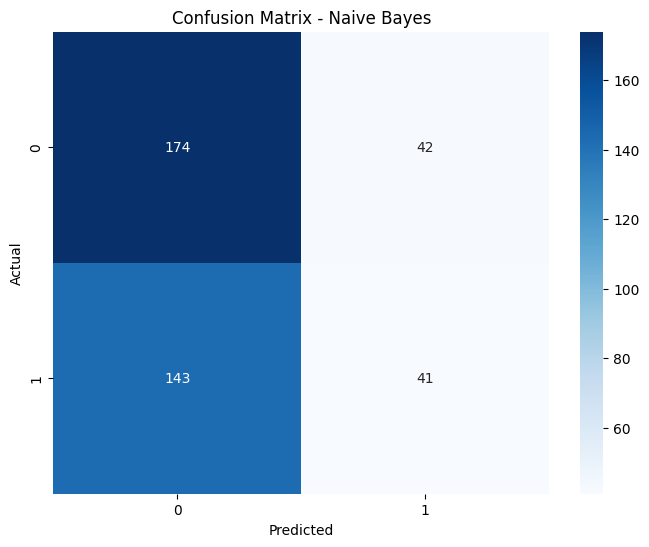

Accuracy of XGBoost on test set: 0.5525
Classification Report for XGBoost:
               precision    recall  f1-score   support

       False       0.55      1.00      0.71       216
        True       0.86      0.03      0.06       184

    accuracy                           0.55       400
   macro avg       0.70      0.51      0.38       400
weighted avg       0.69      0.55      0.41       400



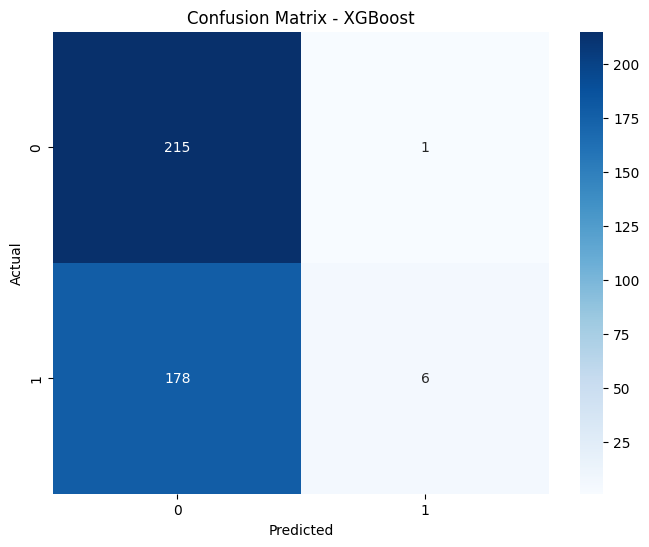

In [ ]:
# Using the best models to fit the data

best_models = hyperparameter_tuning(X_train, y_train)

# Evaluate the best models on the test set
for model_name, model_info in best_models.items():
    model = model_info["best_estimator"]
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name} on test set: {accuracy:.4f}")
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



#### Comparing the accuracy of our models

Accuracy of Logistic Regression on test set: 0.5925
Accuracy of Decision Tree on test set: 0.5500
Accuracy of Random Forest on test set: 0.5500
Accuracy of Gradient Boosting on test set: 0.5300
Accuracy of AdaBoost on test set: 0.5475
Accuracy of K-Nearest Neighbors on test set: 0.5550
Accuracy of Naive Bayes on test set: 0.5375
Accuracy of XGBoost on test set: 0.5525


C:\Users\akash\AppData\Local\Temp\ipykernel_38320\2820372225.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_results.keys()), y=accuracy_scores, palette='viridis')


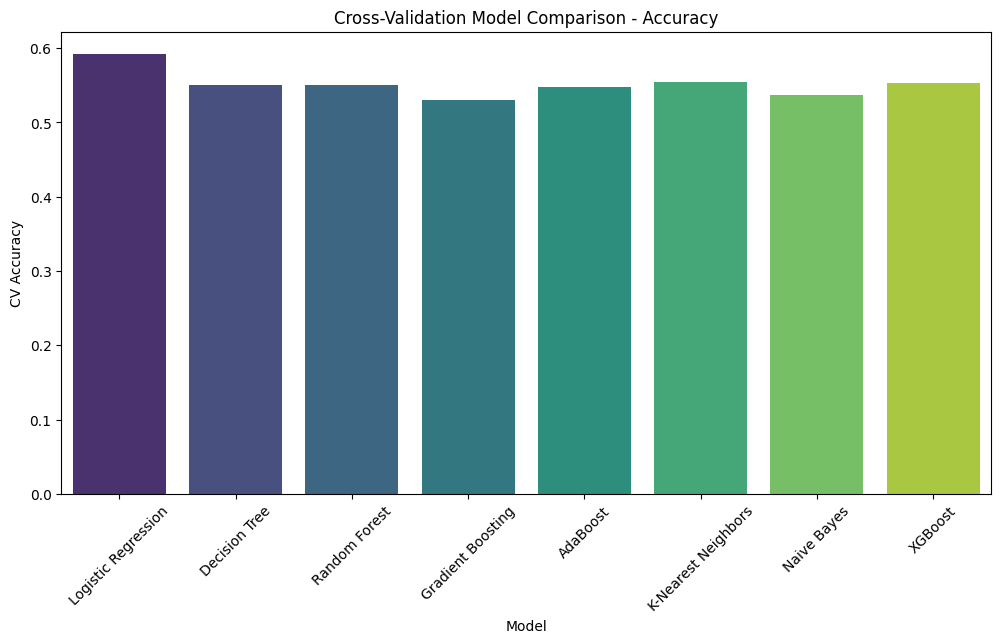

In [ ]:
accuracy_scores = []
for model_name, model_info in best_models.items():
    model = model_info["best_estimator"]
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name} on test set: {accuracy:.4f}")
    accuracy_scores.append(accuracy)
# Plotting the results
model_results = {model_name: model_info["best_score"] for model_name, model_info in best_models.items()}
plt.figure(figsize=(12, 6))
sns.barplot(x=list(model_results.keys()), y=accuracy_scores, palette='viridis')
plt.title("Cross-Validation Model Comparison - Accuracy")
plt.xlabel("Model")
plt.ylabel("CV Accuracy")
plt.xticks(rotation=45)
plt.show()

### Using our models for xG prediction

In [ ]:
final_df = X_test.copy()
for model_name, model_info in best_models.items():
    model = model_info["best_estimator"]
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    final_df[f'{model_name} Goal_Probability'] = y_pred_proba

In [ ]:
final_df.head(10)

,x,y,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,Head,...,Zone_Left,Zone_Right,Logistic Regression Goal_Probability,Decision Tree Goal_Probability,Random Forest Goal_Probability,Gradient Boosting Goal_Probability,AdaBoost Goal_Probability,K-Nearest Neighbors Goal_Probability,Naive Bayes Goal_Probability,XGBoost Goal_Probability
0,60.913824,48.245528,False,True,True,True,False,False,False,False,...,False,False,0.016812,0.050355,0.015274,0.031531,0.236625,0.0,0.000000e+00,0.035044
1,63.979926,50.003274,False,True,True,True,False,False,False,False,...,False,False,0.832474,0.336013,0.360966,0.384007,0.372524,0.0,3.883081e-25,0.397447
2,75.964828,59.448978,False,True,True,True,False,False,False,False,...,True,False,0.203090,0.050355,0.030142,0.052668,0.316075,0.0,2.411998e-16,0.048830
3,64.831862,41.618975,False,True,True,True,False,False,False,False,...,False,False,0.122945,0.050355,0.168960,0.099904,0.236625,0.0,1.000000e+00,0.032437
4,95.794896,42.907939,True,False,True,False,True,False,False,False,...,False,True,0.704171,0.050355,0.238559,0.183071,0.310996,0.2,9.323467e-25,0.084566
5,61.812306,48.801876,True,False,True,False,True,False,True,False,...,False,False,0.016560,0.050355,0.162258,0.096969,0.198539,0.0,5.034085e-80,0.036225
6,91.523146,60.372023,False,True,True,False,True,False,True,False,...,False,True,0.903652,0.050355,0.251584,0.186786,0.323110,0.5,1.000000e+00,0.097168
7,94.660851,47.216691,True,False,True,False,False,False,False,False,...,False,False,0.438070,0.599222,0.375313,0.430609,0.498625,0.8,0.000000e+00,0.478048
8,88.412264,67.167643,True,False,True,True,False,False,False,False,...,False,False,0.026630,0.050355,0.030335,0.063818,0.299404,0.0,0.000000e+00,0.070348
9,77.772704,57.977527,True,False,True,False,False,False,False,True,...,False,False,0.025586,0.050355,0.171672,0.255894,0.248746,0.0,1.359299e-77,0.058034


In [ ]:
final_df.sort_values(by='AdaBoost Goal_Probability', ascending=False).head()

,x,y,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,FirstTouch,Head,...,Zone_Left,Zone_Right,Logistic Regression Goal_Probability,Decision Tree Goal_Probability,Random Forest Goal_Probability,Gradient Boosting Goal_Probability,AdaBoost Goal_Probability,K-Nearest Neighbors Goal_Probability,Naive Bayes Goal_Probability,XGBoost Goal_Probability
367,95.598490,46.154291,False,True,True,False,True,False,False,False,...,True,False,0.944984,0.599222,0.542250,0.619260,0.540387,0.8,3.889371e-15,0.547210
372,90.908784,51.748780,True,False,False,True,False,False,False,False,...,False,True,0.971624,0.830769,0.549288,0.598547,0.536669,0.2,0.000000e+00,0.542533
38,96.968646,45.351192,False,True,True,False,False,False,False,False,...,False,False,0.931731,0.599222,0.500562,0.491630,0.524236,0.4,1.000000e+00,0.530710
73,93.382664,48.688597,True,False,False,True,False,False,False,False,...,False,False,0.950569,0.853659,0.668032,0.744063,0.520504,0.7,0.000000e+00,0.642498
374,80.654779,29.288840,True,False,False,True,False,False,False,False,...,True,False,0.923644,0.853659,0.586033,0.763494,0.512287,0.0,1.418240e-07,0.574814


### Player performance based on xG

In [ ]:
# Sum up the goal probabilities 
print(f'Actual goals scored: {num_goals}')  
for model_name, model_info in best_models.items():
    print(f"xG of {model_name} Goal Probabilities: {final_df[f'{model_name} Goal_Probability'].sum():.4f}")

Actual goals scored: 184
xG of Logistic Regression Goal Probabilities: 131.3543
xG of Decision Tree Goal Probabilities: 44.0728
xG of Random Forest Goal Probabilities: 78.9185
xG of Gradient Boosting Goal Probabilities: 70.7906
xG of AdaBoost Goal Probabilities: 130.9031
xG of K-Nearest Neighbors Goal Probabilities: 49.3000
xG of Naive Bayes Goal Probabilities: 83.1681
xG of XGBoost Goal Probabilities: 50.2027


#### xG Model Visualization

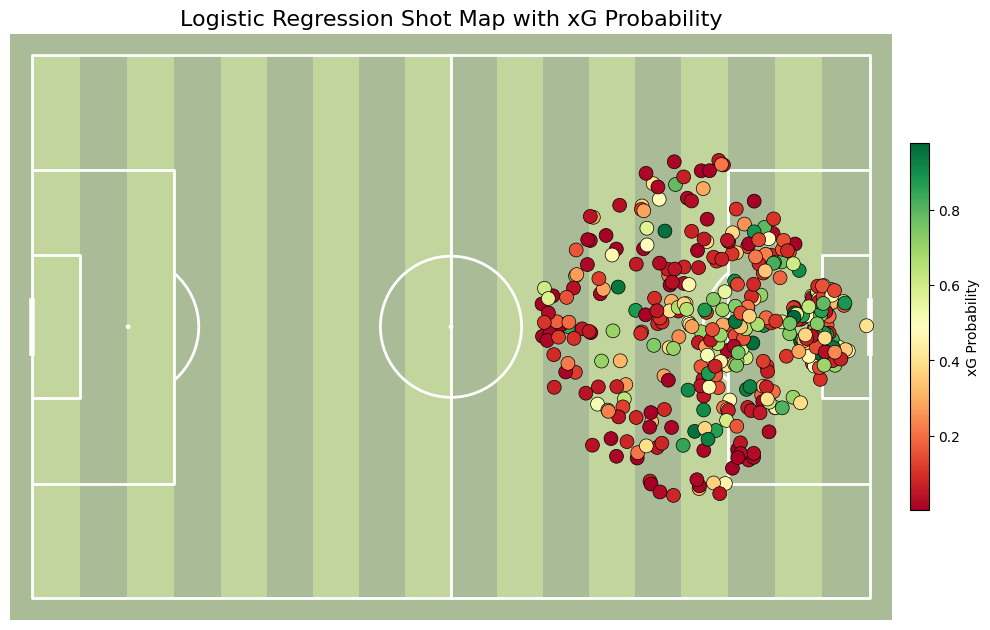

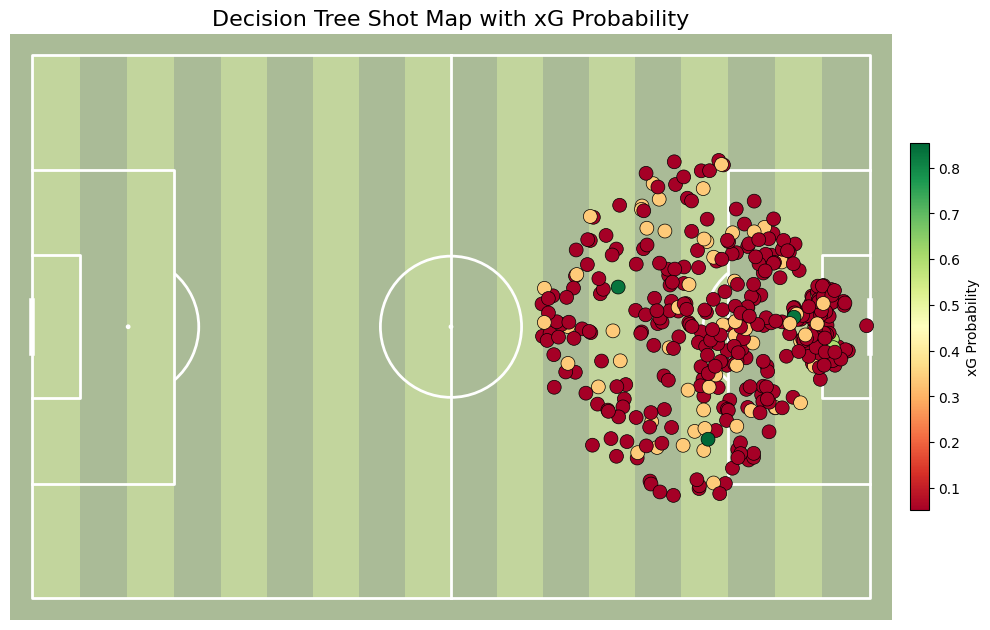

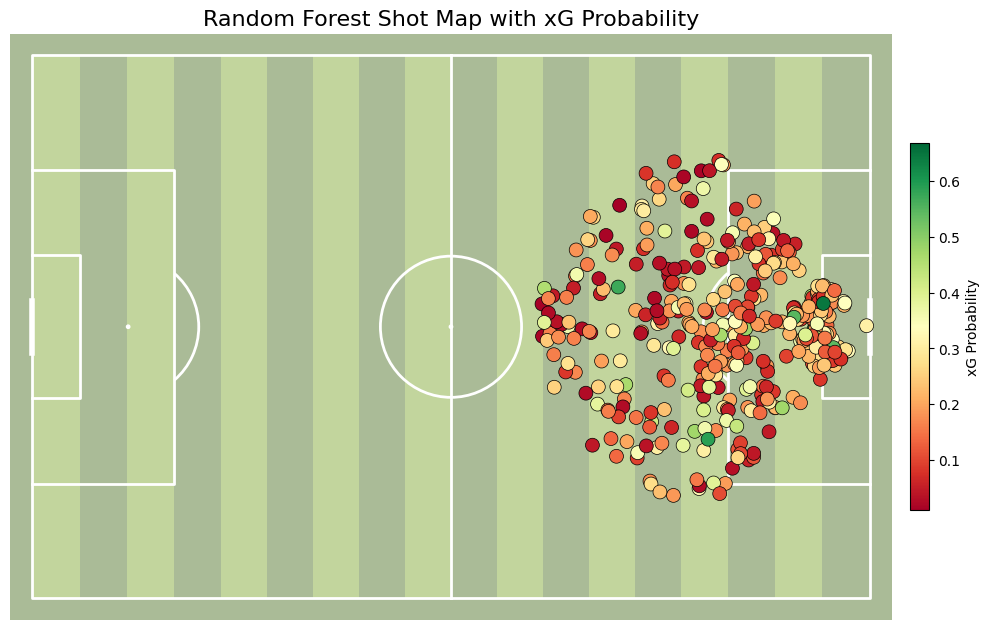

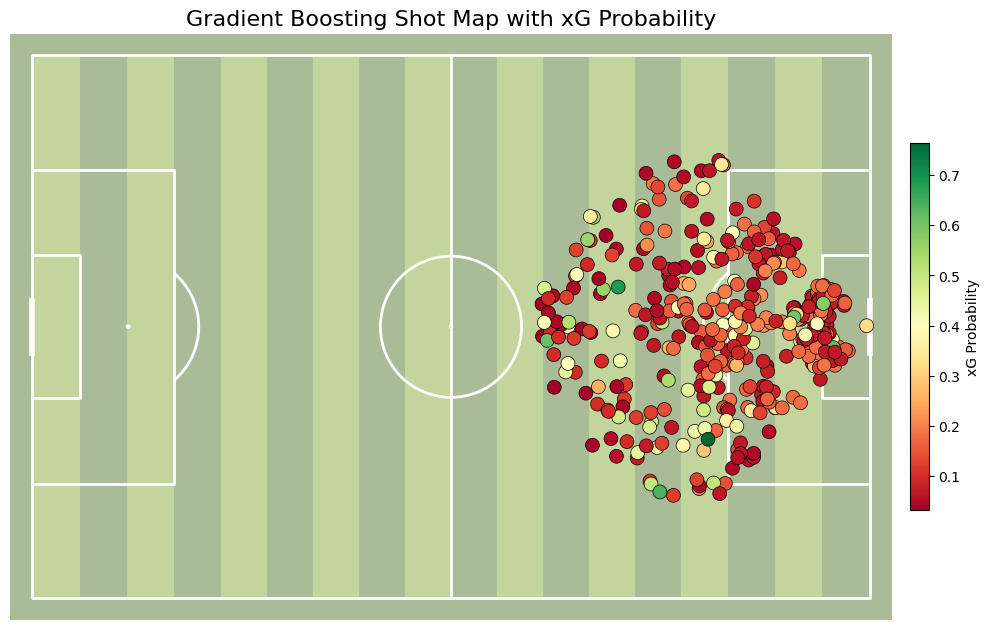

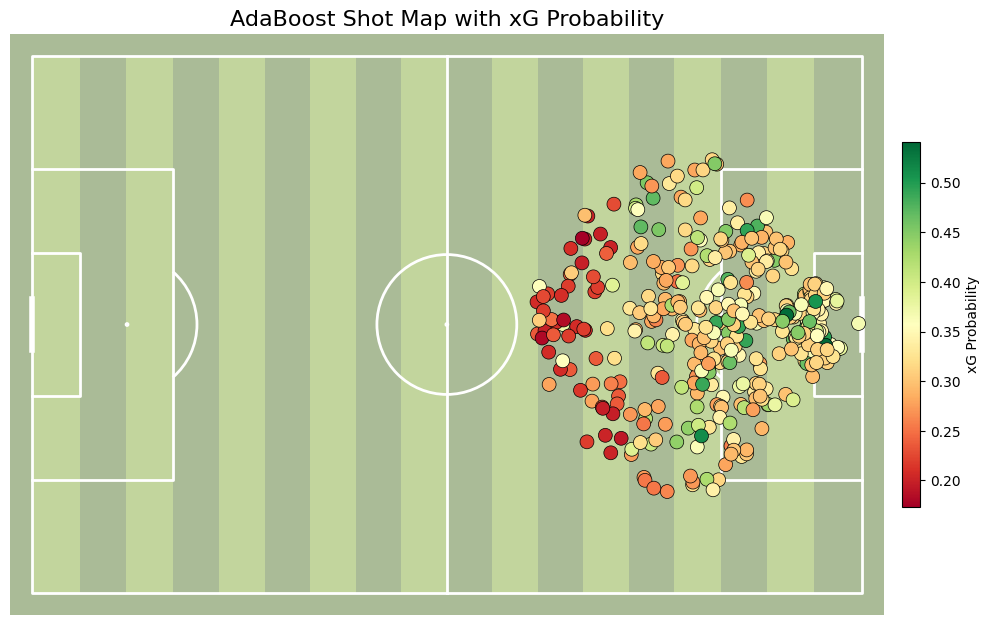

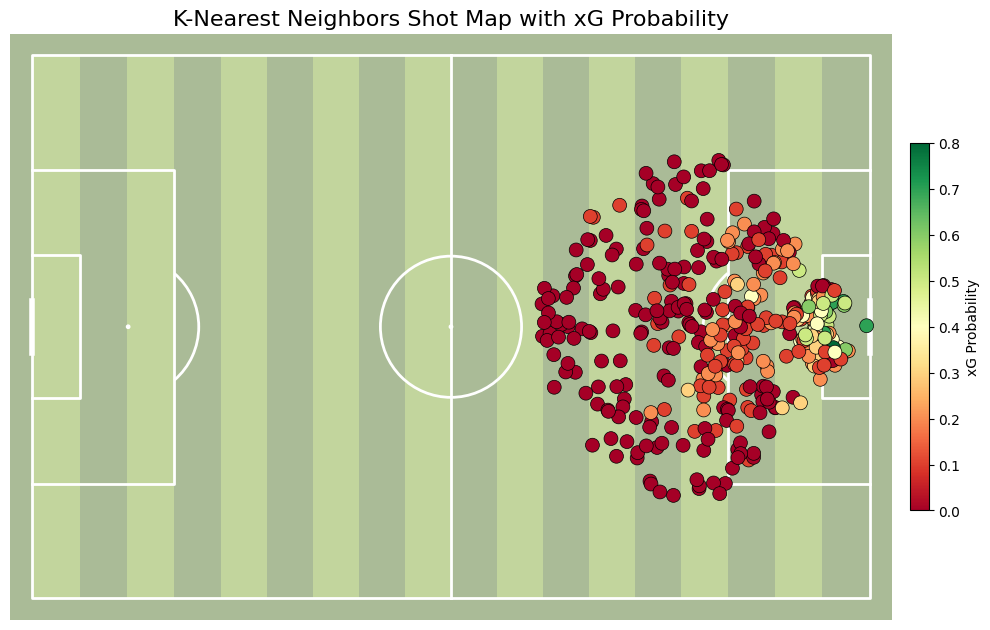

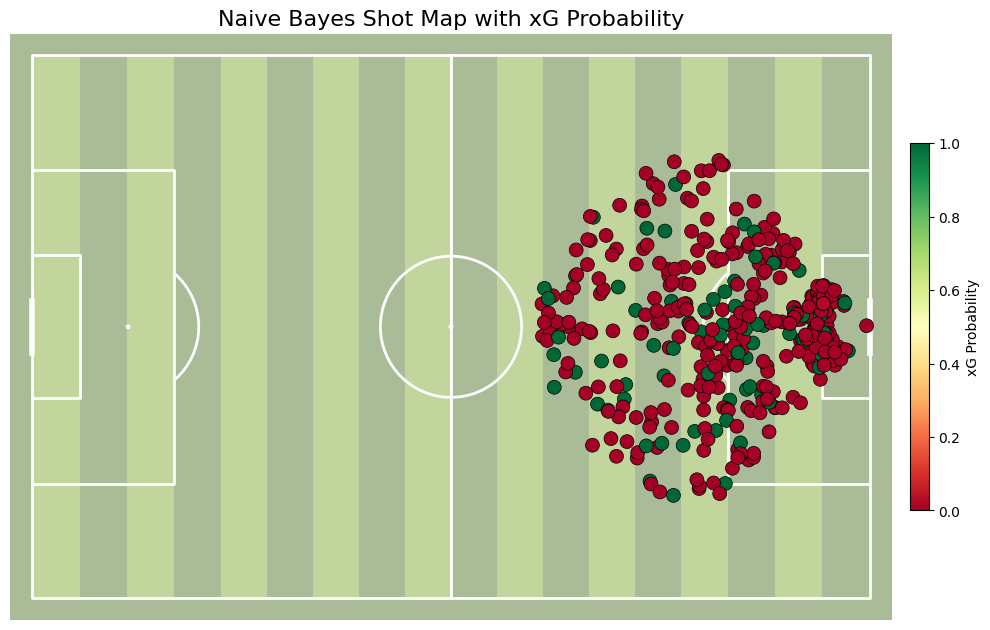

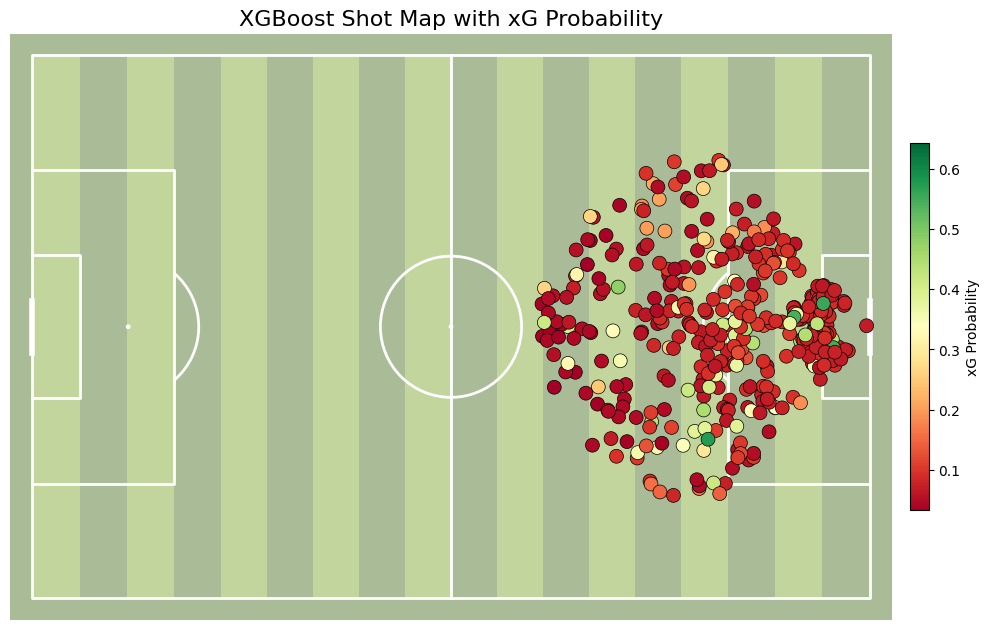

In [ ]:
from mplsoccer import Pitch
from matplotlib.colors import LinearSegmentedColormap

methods=['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'AdaBoost', 'K-Nearest Neighbors', 'Naive Bayes', 'XGBoost']
for method in methods:

    pitch = Pitch(pitch_type='opta', pitch_color='#aabb97', line_color='white',
                  stripe_color='#c2d59d', stripe=True)
    
    cmap = plt.get_cmap('RdYlGn')
    fig, ax = pitch.draw(figsize=(10, 8))
    
    # Scatter plot for shots with xG as the color
    sc = pitch.scatter(
        final_df['x'], 
        final_df['y'],  # Shot coordinates
        c=final_df[f'{method} Goal_Probability'],  # xG probabilities for color
        cmap=cmap,  # Red to green gradient
        edgecolors='black', linewidth=0.5, s=100,  # Point styling
        ax=ax
    )
    
    # Add a color bar to indicate xG values
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label('xG Probability')

    ax.set_title(f'{method} Shot Map with xG Probability', fontsize=16)

    plt.show()


checking xG of each player

In [ ]:
df2.head()

,player_name,x,y,is_goal,Assisted,IndividualPlay,RegularPlay,LeftFoot,RightFoot,FromCorner,...,Zone_Left,Zone_Right,Logistic Regression_predicted_xG,Decision Tree_predicted_xG,Random Forest_predicted_xG,Gradient Boosting_predicted_xG,AdaBoost_predicted_xG,K-Nearest Neighbors_predicted_xG,Naive Bayes_predicted_xG,XGBoost_predicted_xG
0,Akash,60.913824,48.245528,False,False,True,True,True,False,False,...,False,False,0.016812,0.050355,0.015274,0.031531,0.236625,0.0,0.000000e+00,0.035044
1,Akash,63.979926,50.003274,True,False,True,True,True,False,False,...,False,False,0.832474,0.336013,0.360966,0.384007,0.372524,0.0,3.883081e-25,0.397447
2,Akash,75.964828,59.448978,False,False,True,True,True,False,False,...,True,False,0.203090,0.050355,0.030142,0.052668,0.316075,0.0,2.411998e-16,0.048830
3,Akash,64.831862,41.618975,False,False,True,True,True,False,False,...,False,False,0.122945,0.050355,0.168960,0.099904,0.236625,0.0,1.000000e+00,0.032437
4,Akash,95.794896,42.907939,False,True,False,True,False,True,False,...,False,True,0.704171,0.050355,0.238559,0.183071,0.310996,0.2,9.323467e-25,0.084566


In [ ]:
# Group by 'player_name' and sum the 'is_goal' column
player_goal_counts = df2.groupby('player_name')['is_goal'].sum()

# Display the result
print(player_goal_counts)

player_name
Akash     44
Binod     46
Heshan    47
Imesh     47
Name: is_goal, dtype: int64


### Evaluating Player Performance

- Player performance is based on the ratio between the Actual number of goals scored and total xG. 

- A player is underperforming if this ratio is less than 1 and overperforming if greater than 1.

- All 4 players are overperforming their xGs across all models. But the results from Logistic Regression and AdaBoost seem more believable!

- The best players Imesh and Heshan overperform their xG by 1.5 times, which in actual footballing world is quite an overperformance and is rarely seen.

- Other models show a near 5 fold overperformance (which is quite laughable!). Top put things in context, the best performing period of any player ever was in 2012-13 period for Lionel Messi and his overperformance was about 2.5 Goal/xG. 

In [ ]:
# Loop through all the best models and calculate xG for each player
for model_name, model_info in best_models.items():
    print(f"Processing model: {model_name}")
    
    # Get the best estimator for the current model
    model = model_info["best_estimator"]
    
    # Add predicted xG probabilities to the test DataFrame
    df2[f"{model_name}_predicted_xG"] = model.predict_proba(X_test)[:, 1]
    
    # Group by 'player_name' to calculate total xG and actual goals
    player_stats = df2.groupby("player_name").agg(
        actual_goals=("is_goal", "sum"),
        total_xG=(f"{model_name}_predicted_xG", "sum")
    ).reset_index()
    
    # Display the comparison for the current model
    print(f"Results for {model_name}:")
    #print(player_stats)
    

    # Optionally, sort by total xG or actual goals
    player_stats = player_stats.sort_values(by="total_xG", ascending=False)
    print(player_stats)
    print("\n")

# Make a dataframe to store the results according the each method
results_df = pd.DataFrame(columns=['Player', 'Model', 'Total xG', 'Actual Goals'])
# Loop through all the best models and calculate xG for each player
for model_name, model_info in best_models.items():
    print(f"Processing model: {model_name}")
    
    # Get the best estimator for the current model
    model = model_info["best_estimator"]
    
    # Add predicted xG probabilities to the test DataFrame
    df2[f"{model_name}_predicted_xG"] = model.predict_proba(X_test)[:, 1]
    
    # Group by 'player_name' to calculate total xG and actual goals
    player_stats = df2.groupby("player_name").agg(
        actual_goals=("is_goal", "sum"),
        total_xG=(f"{model_name}_predicted_xG", "sum")
    ).reset_index()
    
    # Append results to the results_df DataFrame
    for _, row in player_stats.iterrows():
    # Create a new DataFrame for the row to append
        new_row = pd.DataFrame([{
        'Player': row['player_name'],
        'Model': model_name,
        'Total xG': row['total_xG'],
        'Actual Goals': row['actual_goals']
    }])
    
# Use pd.concat to append the new row to results_df
        results_df = pd.concat([results_df, new_row], ignore_index=True)
# Display the results DataFrame
results_df['Performance'] = results_df['Actual Goals'] / results_df['Total xG']

# I want to see only Adaboost and Logistic Regression sorted in descending order of performance
results_df = results_df[(results_df['Model'] == 'AdaBoost') | (results_df['Model'] == 'Logistic Regression')]
results_df = results_df.sort_values(by='Performance', ascending=False)
# Display the final results
results_df

Processing model: Logistic Regression
Results for Logistic Regression:
  player_name  actual_goals   total_xG
0       Akash            44  35.224729
1       Binod            46  32.425919
2      Heshan            47  31.949888
3       Imesh            47  31.753718


Processing model: Decision Tree
Results for Decision Tree:
  player_name  actual_goals   total_xG
3       Imesh            47  12.024290
0       Akash            44  11.221427
2      Heshan            47  11.011888
1       Binod            46   9.815147


Processing model: Random Forest
Results for Random Forest:
  player_name  actual_goals   total_xG
3       Imesh            47  20.281269
2      Heshan            47  20.160006
0       Akash            44  19.773658
1       Binod            46  18.703576


Processing model: Gradient Boosting
Results for Gradient Boosting:
  player_name  actual_goals   total_xG
3       Imesh            47  18.322764
2      Heshan            47  17.965287
1       Binod            46  17.2717

C:\Users\akash\AppData\Local\Temp\ipykernel_38320\2233639625.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Processing model: Decision Tree
Processing model: Random Forest
Processing model: Gradient Boosting
Processing model: AdaBoost
Processing model: K-Nearest Neighbors
Processing model: Naive Bayes
Processing model: XGBoost


,Player,Model,Total xG,Actual Goals,Performance
3,Imesh,Logistic Regression,31.753718,47,1.480142
2,Heshan,Logistic Regression,31.949888,47,1.471054
17,Binod,AdaBoost,31.748665,46,1.44888
18,Heshan,AdaBoost,33.080765,47,1.420765
1,Binod,Logistic Regression,32.425919,46,1.418618
19,Imesh,AdaBoost,33.285111,47,1.412043
16,Akash,AdaBoost,32.788546,44,1.341932
0,Akash,Logistic Regression,35.224729,44,1.249122
